In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from keras.layers import *
from keras.models import *
from keras.metrics import *
from keras.callbacks import *

from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import *

Using TensorFlow backend.


In [2]:
x_train = pd.read_csv("../input/X_train.csv")
x_test = pd.read_csv("../input/X_test.csv")
y_train = pd.read_csv("../input/y_train.csv")
x_train.sort_values(['series_id', 'measurement_number'], inplace=True)
x_test.sort_values(['series_id', 'measurement_number'], inplace=True)

In [3]:
def quaternion_to_euler(x, y, z, w):
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = math.atan2(t0, t1)
    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.asin(t2)
    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = math.atan2(t3, t4)
    return X, Y, Z

def extra_columns(df):
    x, y, z, w = df['orientation_X'].tolist(), df['orientation_Y'].tolist(), df['orientation_Z'].tolist(), df['orientation_W'].tolist()
    nx, ny, nz = [], [], []
    for i in range(len(x)):
        xx, yy, zz = quaternion_to_euler(x[i], y[i], z[i], w[i])
        nx.append(xx)
        ny.append(yy)
        nz.append(zz)
    df['deuler_x'] = np.diff(np.array(nx), prepend=0)
    df['deuler_y'] = np.diff(np.array(ny), prepend=0)
    df['deuler_z'] = np.diff(np.array(nz), prepend=0)
    for v in ['deuler_x', 'deuler_y', 'deuler_z']:
        sel = df[v] > math.pi
        df.loc[sel, v] = 2 * math.pi - df[v][sel]
        sel = df[v] < -math.pi
        df.loc[sel, v] = 2 * math.pi + df[v][sel]
      
    df['deuler_2'] = np.sqrt(df['deuler_x']**2 + df['deuler_y']**2 + df['deuler_z']**2)
    df['angular_velocity_2'] = ((df['orientation_X'] * df['orientation_X'].shift(1) + \
                                 df['orientation_Y'] * df['orientation_Y'].shift(1) + \
                                 df['orientation_Z'] * df['orientation_Z'].shift(1)) / 1.001).apply(math.acos)
    df['dorientation_aW'] = np.abs(np.diff(df['orientation_W'], prepend=0))
    df['linear_acceleration'] = np.sqrt(df['linear_acceleration_X']**2 + df['linear_acceleration_Y']**2 + df['linear_acceleration_Z']**2)
    df['angular_velocity'] = np.sqrt(df['angular_velocity_X']**2 + df['angular_velocity_Y']**2 + df['angular_velocity_Z']**2)
    
    df['linear_to_angular'] = df['linear_acceleration'] / (df['angular_velocity'] + 1e-6)
    df['angular_to_linear'] = df['angular_velocity'] / (df['linear_acceleration'] + 1e-6)
    return df

x_train = extra_columns(x_train)
x_test = extra_columns(x_test)
varnames = x_train.columns[3:]

<Figure size 1080x1080 with 0 Axes>

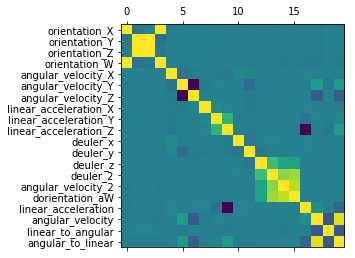

In [4]:
plt.figure(figsize=(15,15))
plt.matshow(pd.concat([x_train, x_test]).drop(['row_id', 'series_id', 'measurement_number'], axis = 1).corr())
# plt.xticks(np.arange(len(varnames)),varnames)
plt.yticks(np.arange(len(varnames)),varnames)
plt.show()

In [5]:
train_seq = []
for i in sorted(x_train['series_id'].unique()):
    seq = x_train[x_train['series_id']==i]
    seq = seq.sort_values("measurement_number")
    train_seq.append(seq.drop(['row_id', 'series_id', 'measurement_number'], axis = 1).values)
test_seq = []
for i in sorted(x_test['series_id'].unique()) :
    seq = x_test[x_test['series_id']==i]
    seq = seq.sort_values("measurement_number")
    test_seq.append(seq.drop(['row_id', 'series_id', 'measurement_number'], axis = 1).values)
    
train_seq = np.array(train_seq)
test_seq = np.array(test_seq)

class_num = y_train['surface'].unique().shape[0]
y_group = y_train['group_id'].values
y_train = pd.get_dummies(y_train['surface'])
label_name = [col for col in y_train.columns]
y_train = y_train.values

In [6]:
diff_features = ['deuler_x', 'deuler_y', 'deuler_z', 'deuler_2', 'dorientation_aW']
for v in diff_features:
    train_seq[:,0,varnames==v] = 0
    test_seq[:,0,varnames==v] = 0
train_seq[:,0,varnames=='angular_velocity_2'] = train_seq[:,1,varnames=='angular_velocity_2']
test_seq[:,0,varnames=='angular_velocity_2']  =  test_seq[:,1,varnames=='angular_velocity_2']

In [7]:
means = np.mean(train_seq, axis=(0,1))
std = np.std(train_seq, axis=(0,1))
train_seq = (train_seq - means[np.newaxis,np.newaxis,:]) / std[np.newaxis,np.newaxis,:]
test_seq = (test_seq - means[np.newaxis,np.newaxis,:]) / std[np.newaxis,np.newaxis,:]

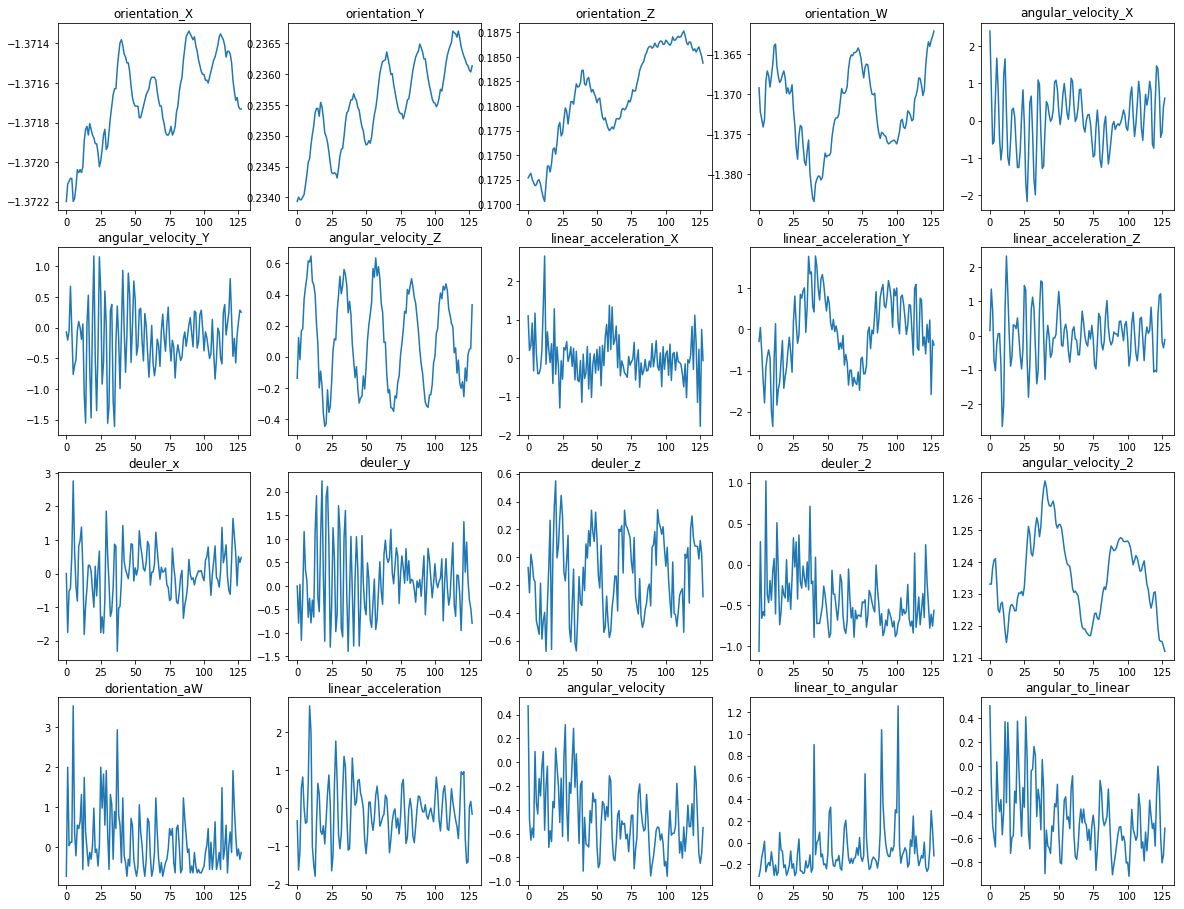

In [8]:
plt.figure(figsize=(20,20))
for i in range(len(varnames)):
    plt.subplot(5,5,i+1)
    plt.title(varnames[i])
    plt.plot(train_seq[1,:,i])
plt.show()

In [9]:
def res_block(nchannels, ksize, x):
    y = x
    y = layers.ELU()(y)
    y = layers.BatchNormalization()(y)
    y = layers.Conv1D(nchannels, ksize, padding='same')(y)
    y = layers.ELU()(y)
    y = layers.BatchNormalization()(y)
    y = layers.Conv1D(nchannels, ksize, padding='same')(y)
    x = layers.add([x, y])
    return x
    
def cnn_model(input_shape, class_num) :
    inp = Input((input_shape[1], input_shape[2]))
    x = layers.BatchNormalization(axis=2)(inp)
    x = layers.Conv1D(32, 3, padding='same')(x)
    for l in range(4):
        x = res_block(32, 3, x)
        x = res_block(32, 3, x)
        x = res_block(32, 3, x)
        x = AveragePooling1D(2)(x)
    x = layers.ELU()(x)
    x = layers.BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(class_num, activation="softmax")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(optimizer="adadelta", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [10]:
from sklearn.model_selection import StratifiedKFold

random_seed = 1
np.random.seed(random_seed)

fold = StratifiedKFold(12, shuffle = True, random_state = random_seed)
oof_train = np.zeros((train_seq.shape[0], class_num))
oof_test = np.zeros((test_seq.shape[0], class_num))
hist = []
for i, (trn, val) in enumerate(list(fold.split(y_train, np.argmax(y_train, axis = 1)))):
    model = cnn_model(train_seq.shape, class_num)
    chk = ModelCheckpoint("best_weight.wt", monitor='val_acc', mode = 'max', save_best_only = True, verbose = 0)
    est = EarlyStopping(patience=200, verbose = 0)
    rlp = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=50, min_lr=0.01, verbose = 0)
    hist.append(model.fit(train_seq[trn], y_train[trn], verbose = 0,
                          epochs = 500, batch_size = 3072,
                          validation_data = [train_seq[val], y_train[val]],
                          callbacks = [chk, est, rlp]))
    model.load_weights("best_weight.wt")
    oof_train[val] = model.predict(train_seq[val])
    oof_test += model.predict(test_seq) / fold.n_splits

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [11]:
print('OOF metrics\nAcc: %f\nLoss: %f' % (np.mean(K.eval(categorical_accuracy(y_train, oof_train))),
                             np.mean(K.eval(categorical_crossentropy(K.constant(y_train), K.constant(oof_train))))))

OOF metrics
Acc: 0.931759
Loss: 0.279518


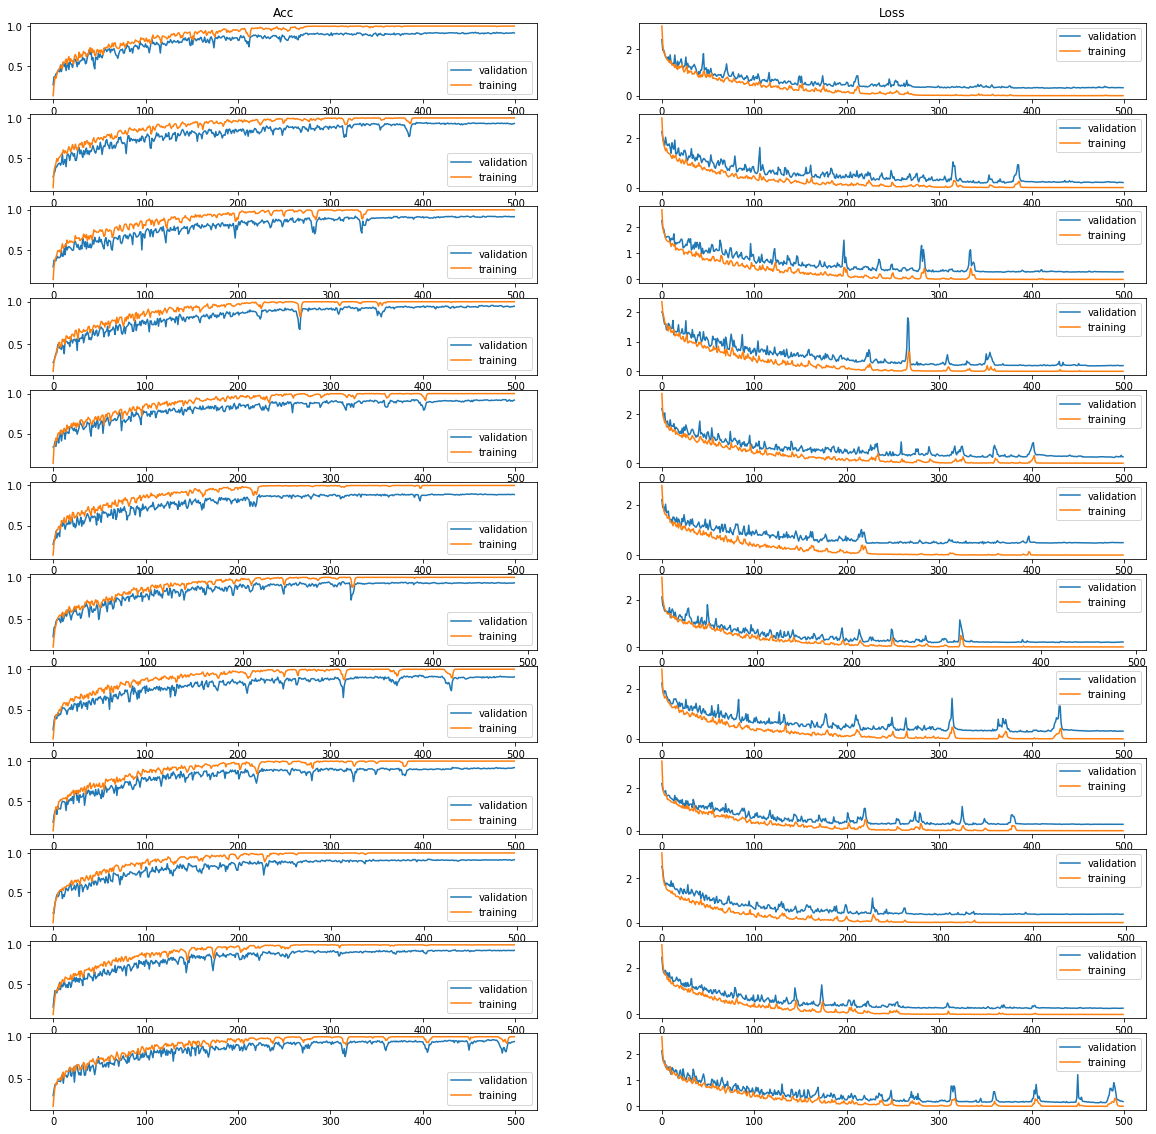

In [12]:
plt.figure(figsize=(20,20))
nfolds = len(hist)
for i in range(nfolds):
    plt.subplot(nfolds, 2, 2*i+1)
    plt.plot(hist[i].history['val_acc'])
    plt.plot(hist[i].history['acc'])
    if i == 0: plt.title('Acc')
    plt.legend(["validation", "training"])
    plt.subplot(nfolds, 2, 2*i+2)
    plt.plot(hist[i].history['val_loss'])
    plt.plot(hist[i].history['loss'])
    if i == 0: plt.title('Loss')
    plt.legend(["validation", "training"])
plt.show()

In [13]:
submission = pd.read_csv("../input/sample_submission.csv")
submission['surface'] = pd.DataFrame(np.argmax(oof_test, axis = 1))[0].apply(lambda x : label_name[x]).values.reshape(-1)
submission.to_csv("submission.csv", index = False)

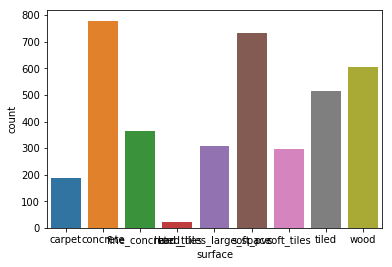

In [14]:
sns.countplot(x="surface", data=pd.read_csv("../input/y_train.csv"), order=label_name)

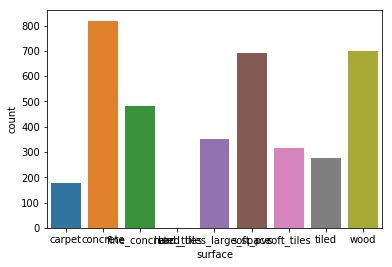

In [15]:
sns.countplot(x="surface", data=submission, order=label_name)